## Single particle Langevin dynamics in two dimensions
This notebook solves the two dimensional Langevin equation using a time-splitting integration method from [this paper](https://aip.scitation.org/doi/full/10.1063/1.4802990). The particle density, fluid viscosity, temperature, potential, and the simulation duration can be varied interactively. Particle size is fixed at 2 $\mu m$ diameter and the time step is fixed at 0.5 ms. 

In [42]:
# Import useful packages
import numpy as np
import time
from collections import deque
import seaborn as sns
import ipywidgets as widgets
from IPython.display import display
from bokeh.io import show, output_notebook, push_notebook
from bokeh.plotting import figure 
from scipy import stats
import sys
output_notebook()

Loading BokehJS ...

In [2]:
pip install tensorflow

  Obtaining dependency information for tensorflow from https://files.pythonhosted.org/packages/7c/95/b291edd75d76708f828039695b5561bdb6db1a95bca43f9087b794bd735a/tensorflow-2.15.0-cp39-cp39-macosx_10_15_x86_64.whl.metadata
  Obtaining dependency information for flatbuffers>=23.5.26 from https://files.pythonhosted.org/packages/6f/12/d5c79ee252793ffe845d58a913197bfa02ae9a0b5c9bc3dc4b58d477b9e7/flatbuffers-23.5.26-py2.py3-none-any.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 1.2 MB/s eta 0:00:00ta 0:00:01
  Obtaining dependency information for libclang>=13.0.0 from https://files.pythonhosted.org/packages/c9/ea/fe2a69cc6cfebf7c7ee8a6357566fc1cbb91632bde5869b669a396accb5f/libclang-16.0.6-py2.py3-none-macosx_10_9_x86_64.whl.metadata
  Obtaining dependency information for ml-dtypes~=0.2.0 from https://files.pythonhosted.org/packages/f0/d8/f602f05db13d187884ddb5ae4e823d333beb28bbd3d12c057450afa3acee/ml_dtypes-0.2.0-cp39-cp39-macosx_10_9_universal2.whl.metadata
     ━

  Obtaining dependency information for cachetools<6.0,>=2.0.0 from https://files.pythonhosted.org/packages/a2/91/2d843adb9fbd911e0da45fbf6f18ca89d07a087c3daa23e955584f90ebf4/cachetools-5.3.2-py3-none-any.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 151.7/151.7 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 239.1/239.1 MB 6.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.7/9.7 MB 8.8 MB/s eta 0:00:0000:0100:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 8.0 MB/s eta 0:00:0000:0100:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.5/24.5 MB 9.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 13.9 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 8.2 MB/s eta 0:00:0000:0100:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.3/400.3 kB 8.1 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.0/442.0 kB 12.1 MB/s eta 0:00:00
   ━━━━

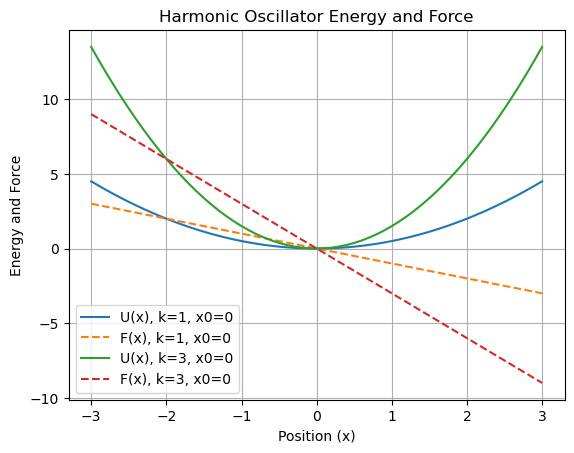

In [4]:
# Harmonic Ossilator energy 
import numpy as np
import matplotlib.pyplot as plt

def harmonic_oscillator_energy_force(x, k=1, x0=0):
    energy = 0.5 * k * (x - x0) ** 2
    force = -k * (x - x0)
    return energy, force

def plot_energy_force(function, xmin=-3, xmax=3, spacing=0.1, k=1, x0=0):
    x_points = np.arange(xmin, xmax + spacing, spacing)
    energies, forces = function(x_points, k, x0)
    plt.plot(x_points, energies, label=f'U(x), k={k}, x0={x0}')
    plt.plot(x_points, forces, '--', label=f'F(x), k={k}, x0={x0}')
    plt.legend(loc=0)
    plt.xlabel('Position (x)')
    plt.ylabel('Energy and Force')
    plt.title('Harmonic Oscillator Energy and Force')
    plt.grid(True)

# Example Usage:
plot_energy_force(harmonic_oscillator_energy_force, k=1)
plot_energy_force(harmonic_oscillator_energy_force, k=3)
plt.show()

In [4]:
import numpy as np

def update_position(current_pos, current_velocity, time_step):
    x_new = current_pos + current_velocity * time_step * 0.5
    return x_new

def update_velocity(current_velocity, force, time_step):
    v_new = current_velocity + force * time_step * 0.5
    return v_new

def update_velocity_with_randomness(current_velocity, damping, temp, time_step):
    
    random_force = np.random.normal()
    damping_factor = np.exp(-damping * time_step)
    stochastic_factor = np.sqrt(1 - damping_factor ** 2) * np.sqrt(temp)
    v_new = damping_factor * current_velocity + random_force * stochastic_factor
    return v_new

def simulate_dynamics(potential_func, max_simulation_time, time_step, damping, temperature, 
                      initial_pos, initial_velocity, save_interval=3, **kwargs):
    
    x = initial_pos
    v = initial_velocity
    time = 0
    step_number = 0
    recorded_positions = []
    recorded_velocities = []
    recorded_energies = []
    recorded_squared_positions = []
    recorded_times = [] 

    while(time < max_simulation_time):
        
        # Step B
        potential_energy, force = potential_func(x,**kwargs)
        v = update_velocity(v, force, time_step)
        
        # Step A
        x = update_position(x, v, time_step)

        # Step O
        v = update_velocity_with_randomness(v, damping, temperature, time_step)
        
        # Step A
        x = update_position(x, v, time_step)
        
        # Step B
        potential_energy, force = potential_func(x,**kwargs)
        v = update_velocity(v, force, time_step)
        
        # Save data at specified intervals
        if step_number % save_interval == 0 and step_number>0:
            total_energy = 0.5 * v ** 2 + potential_energy
            

            recorded_positions.append(x)
            recorded_squared_positions.append(x*x)
            recorded_velocities.append(v)
            recorded_energies.append(total_energy)
            recorded_times.append(time)
        
        time += time_step
        step_number = step_number + 1
    
    return recorded_times, recorded_positions, recorded_velocities, recorded_energies,recorded_squared_positions


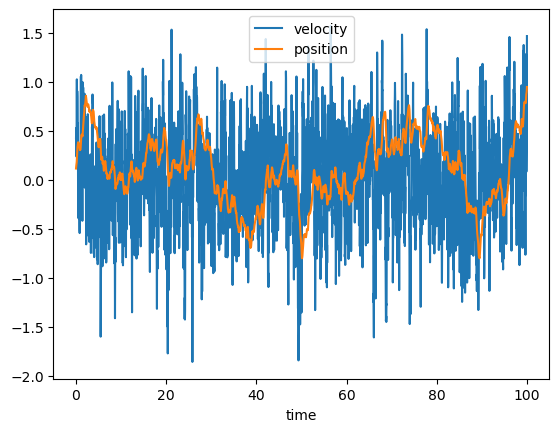

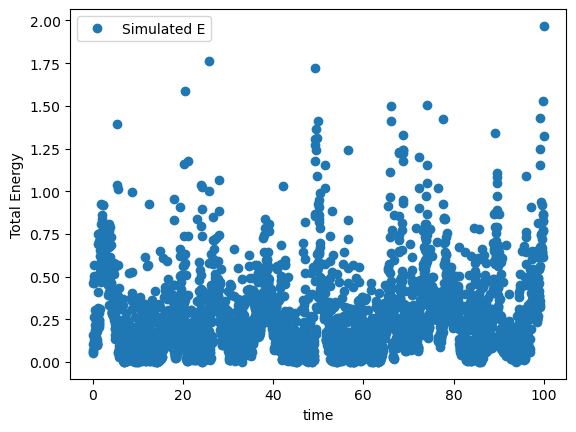

In [5]:
k = 2
max_time = 100
initial_position = .1
initial_velocity = .5

damping=10
temperature=0.25
time_step=0.01

times, positions, velocities, total_energies,squared_positions = simulate_dynamics(harmonic_oscillator_energy_force, \
                                                                            max_time, time_step, damping, temperature, \
                                                                            initial_position, initial_velocity,\
                                                                            k=k)

plt.plot(times,velocities,marker='',label='velocity',linestyle='-')
plt.plot(times,positions,marker='',label='position',linestyle='-')

plt.xlabel('time')
plt.legend(loc='upper center')

plt.figure()
plt.plot(times,total_energies,marker='o',linestyle='',label='Simulated E')
plt.xlabel('time')
plt.ylabel("Total Energy")
plt.legend()


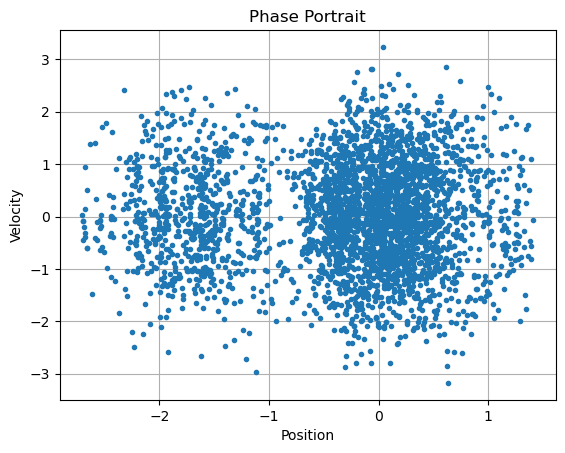

In [6]:
def plot_phase_portrait(positions, velocities):
    plt.figure()
    plt.plot(positions, velocities, '.')
    plt.xlabel('Position')
    plt.ylabel('Velocity')
    plt.title('Phase Portrait')
    plt.grid(True)
    plt.show()


# Example:
times, positions, velocities, total_energies,squared_positions = simulate_dynamics(harmonic_oscillator_energy_force, max_simulation_time=100, time_step=0.01, damping=10, temperature=1, initial_pos=0,initial_velocity = 0)
plot_phase_portrait(positions, velocities)


In [21]:
import numpy as np
import matplotlib.pyplot as plt

# Potential function for a harmonic oscillator
def harmonic_oscillator_energy_force(x, k=1, x0=0):
    energy = 0.5 * k * (x - x0) ** 2
    force = -k * (x - x0)
    return energy, force

# Langevin dynamics simulation function
def simulate_dynamics(potential_func, k, tau, total_time, initial_pos):
    dt = tau
    num_steps = int(total_time / dt)
    x = np.zeros(num_steps)
    x[0] = initial_pos

    # Constants for the stochastic term
    sigma = np.sqrt(2 * dt)

    for i in range(1, num_steps):
        _, force = potential_func(x[i-1], k)
        random_force = np.random.normal(scale=sigma)
        x[i] = x[i-1] + (force * dt) + random_force

    return x

# Parameters for the simulation
gamma = 1.0  # Damping coefficient
k = 1.0  # Spring constant for the harmonic potential
temperature = 1.0  # Temperature (in units where Boltzmann's constant kB=1)
tau = 0.01  # Time constant
total_time = 100  # Total simulation time for reaching equilibrium
initial_pos = 1.0  # Initial position

# Run the simulation
x = simulate_dynamics(harmonic_oscillator_energy_force ,k,tau, total_time, initial_pos)


# Plot the average of x^2 to verify the equipartition theorem
avg_x2 = np.mean(x**2)
print(f"The average of x^2 is approximately {avg_x2}, expected is {temperature/k}.")
time= np.arange(0,total_time,)


The average of x^2 is approximately 1.0100962989293343, expected is 1.0.


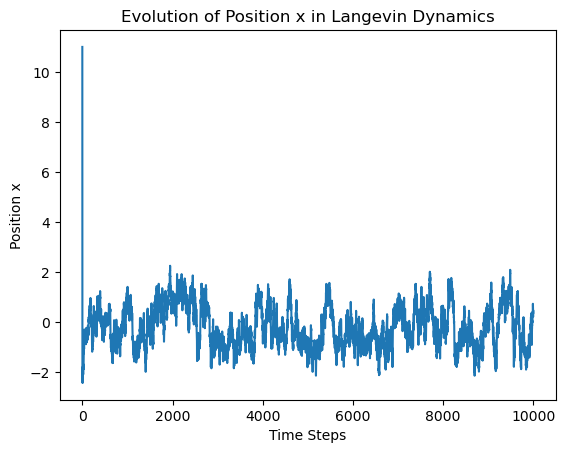

In [66]:
def double_well_potential(x, k=1, x0=0):
    energy = 0.25 * k * (x**2 - x0**2)**2
    force = -k * x * (x**2 - x0**2)
    return energy, force




num_steps = 10000
dt = 0.01
initial_pos = 11.0  # Starting far from the potential well (x=0)
gamma = 1.0
k = 1.0
temperature = 1.0

# Run simulation
x = simulate_dynamics(double_well_potential ,k,tau, total_time, initial_pos)

# Plot the trajectory of x
plt.plot(x)
plt.xlabel('Time Steps')
plt.ylabel('Position x')
plt.title('Evolution of Position x in Langevin Dynamics')
plt.show()


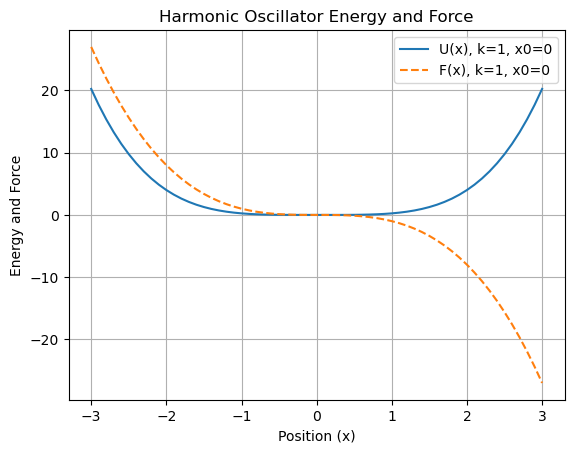

In [64]:
plot_energy_force(double_well_potential, k=1)

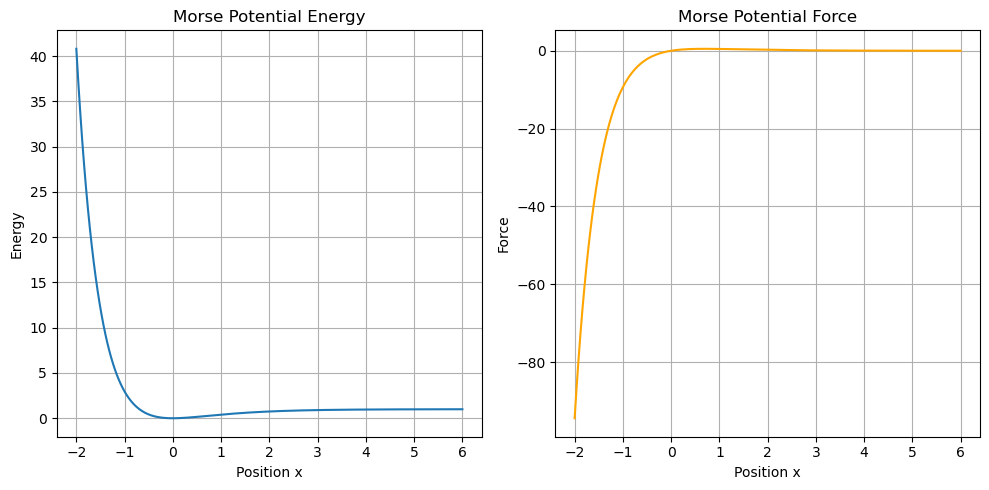

In [69]:
# Create a range of x values
x_values = np.linspace(-2, 6, 400)

# Calculate energy and force for each x value
energies, forces = zip(*[morse_potential(x) for x in x_values])

# Plotting
plt.figure(figsize=(10, 5))

# Energy plot
plt.subplot(1, 2, 1)
plt.plot(x_values, energies, label='Energy')
plt.xlabel('Position x')
plt.ylabel('Energy')
plt.title('Morse Potential Energy')
plt.grid(True)

# Force plot
plt.subplot(1, 2, 2)
plt.plot(x_values, forces, label='Force', color='orange')
plt.xlabel('Position x')
plt.ylabel('Force')
plt.title('Morse Potential Force')
plt.grid(True)

plt.tight_layout()
plt.show()



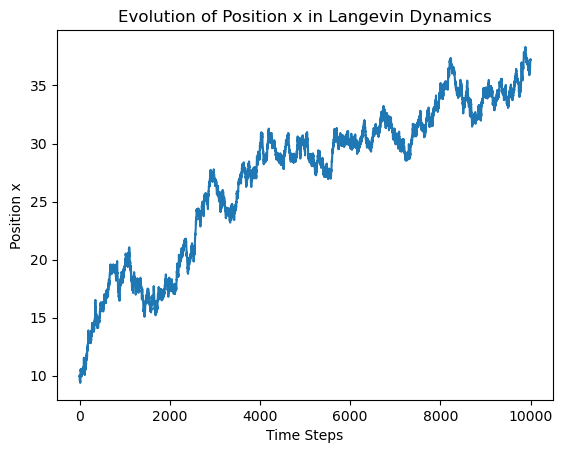

In [71]:
def morse_potential(x, D=1, alpha=1, x0=0):
    energy = D * (1 - np.exp(-alpha * (x - x0)))**2
    force = 2 * alpha * D * (np.exp(-alpha * (x - x0)) - np.exp(-2 * alpha * (x - x0)))
    return energy, force


num_steps = 10000
dt = 0.01
initial_pos = 10.0  # Starting far from the potential well (x=0)
gamma = 1.0
k = 1.0
temperature = 1.0

# Run simulation
x = simulate_dynamics(morse_potential ,k,tau, total_time, initial_pos)

# Plot the trajectory of x
plt.plot(x)
plt.xlabel('Time Steps')
plt.ylabel('Position x')
plt.title('Evolution of Position x in Langevin Dynamics')
plt.show()

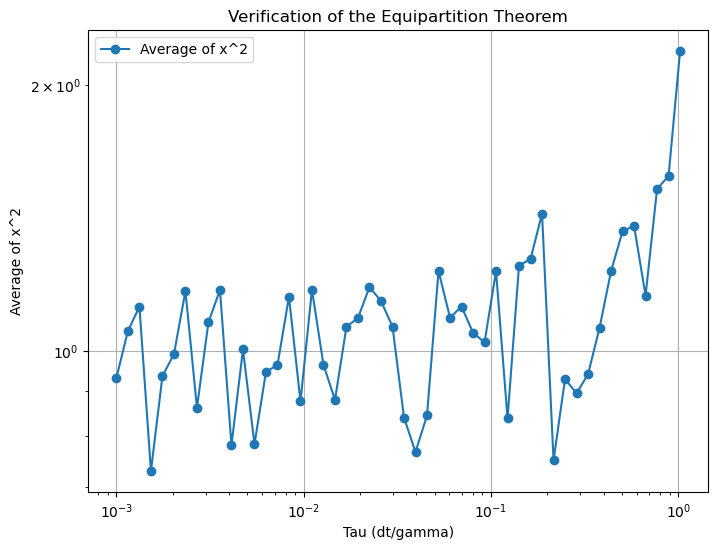

In [17]:
plt.figure(figsize=(8, 6))
plt.loglog(taus, avg_x2_values, '-o', label='Average of x^2')
plt.xlabel('Tau (dt/gamma)')
plt.ylabel('Average of x^2')
plt.title('Verification of the Equipartition Theorem')
plt.legend()
plt.grid(True)
plt.show()

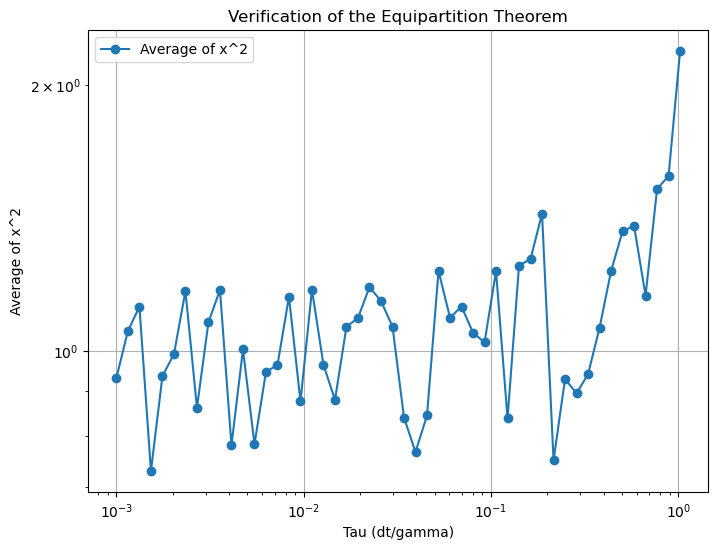

In [7]:
taus = np.logspace(-3, 0.01, num=50)  # Logarithmic spacing of tau
avg_x2_values = []  # To store average x^2 for each tau
x_vals = []

for tau in taus:
    x = simulate_dynamics(harmonic_oscillator_energy_force ,k,tau, total_time, initial_pos)
    x_vals.append(x)
    avg_x2 = np.mean(x**2)
    avg_x2_values.append(avg_x2)

# Plotting
plt.figure(figsize=(8, 6))
plt.loglog(taus, avg_x2_values, '-o', label='Average of x^2')
plt.xlabel('Tau (dt/gamma)')
plt.ylabel('Average of x^2')
plt.title('Verification of the Equipartition Theorem')
plt.legend()
plt.grid(True)
plt.show()

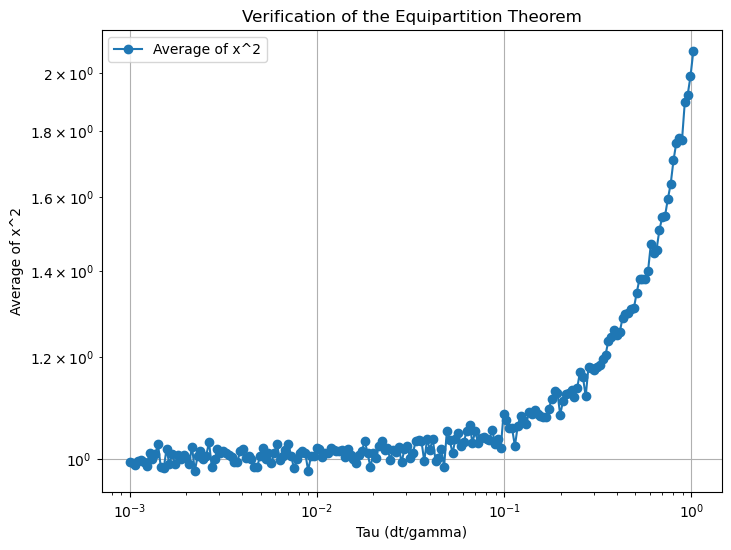

In [1]:
import matplotlib.pyplot as plt
import numpy as np

# Load data from the C++ simulation
data = np.loadtxt('avg_x2_values.txt')
taus = data[:, 0]
avg_x2_values = data[:, 1]

# Plotting
plt.figure(figsize=(8, 6))
plt.loglog(taus, avg_x2_values, '-o', label='Average of x^2')
plt.xlabel('Tau (dt/gamma)')
plt.ylabel('Average of x^2')
plt.title('Verification of the Equipartition Theorem')
plt.legend()
plt.grid(True)
plt.show()


1. To see write a code that works for many parameters, and statrs off the likelyhood with some exponential for the get loglikely hood, see that it works. 

2. Expalin how it handles if we have firm limits, for eg -1 <x <1 , in the intergral,

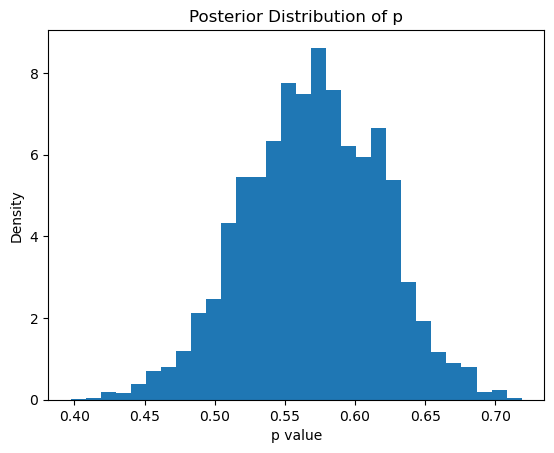

In [43]:

x = 57
n = 100

# Define the Likelihood P(x|p) - binomial distribution
def likelihood(p):
    return stats.binom.pmf(x, n, p)

def prior(p):
    return stats.uniform.pdf(p)


def acceptance_ratio(p, p_new):
    # Return R, using the functions we created before
    return min(1, ((likelihood(p_new) / likelihood(p)) * (prior(p_new) / prior(p))))

results = []

# Initialzie a value of p
p = np.random.uniform(0, 1)

# Define model parameters
n_samples = 25000
burn_in = 5000
lag = 5

# Create the MCMC loop
for i in range(n_samples):
    # Propose a new value of p randomly from a uniform distribution between 0 and 1
    p_new = np.random.random_sample()
    # Compute acceptance probability
    R = acceptance_ratio(p, p_new)
    # Draw random sample to compare R to
    u = np.random.random_sample()
    # If R is greater than u, accept the new value of p (set p = p_new)
    if u < R:
        p = p_new
    # Record values after burn in - how often determined by lag
    if i > burn_in and i%lag == 0:
        results.append(p)
        
        
plt.hist(results, bins=30, density=True)
plt.xlabel('p value')
plt.ylabel('Density')
plt.title('Posterior Distribution of p')
plt.show()



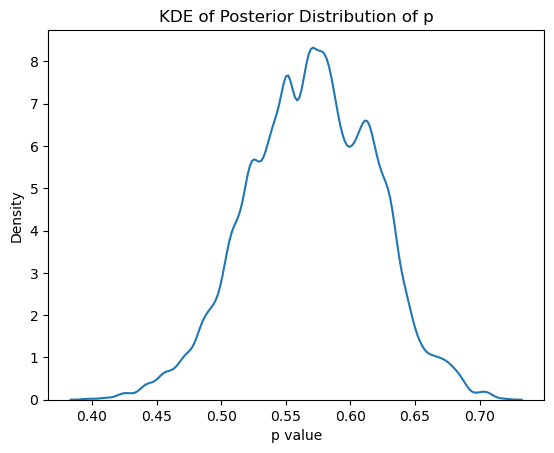

In [44]:
sns.kdeplot(results, bw_adjust=0.5)
plt.xlabel('p value')
plt.ylabel('Density')
plt.title('KDE of Posterior Distribution of p')
plt.show()

In [45]:
import numpy as np
import scipy.stats as stats

# Example data: assuming it's time between events or similar
data = np.array([2.3, 1.7, 4.4, 3.1])  # Replace with your actual data

# Define the exponential likelihood function
def likelihood(lam):
    # Using the PDF of the exponential distribution
    return np.prod(stats.expon.pdf(data, scale=1/lam))

def prior(lam):
    # Assuming a uniform prior for simplicity
    if 0 < lam < 10:  # Adjust range according to your knowledge of the problem
        return 1 / 10
    else:
        return 0

def acceptance_ratio(lam, lam_new):
    return min(1, (likelihood(lam_new) * prior(lam_new)) / (likelihood(lam) * prior(lam)))

results = []

# Initialize a value of lambda
lam = np.random.uniform(0.1, 10)

# Define model parameters
n_samples = 25000
burn_in = 5000
lag = 5

# MCMC loop
for i in range(n_samples):
    lam_new = np.random.uniform(0.1, 10)  # Propose a new value of lambda
    R = acceptance_ratio(lam, lam_new)
    u = np.random.random_sample()
    if u < R:
        lam = lam_new
    if i > burn_in and i % lag == 0:
        results.append(lam)

        

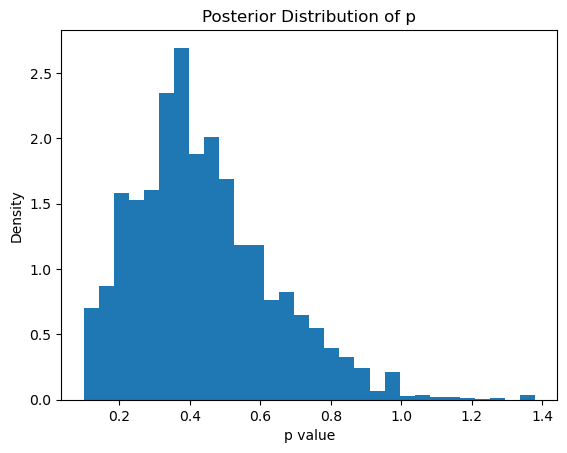

In [46]:
plt.hist(results, bins=30, density=True)
plt.xlabel('p value')
plt.ylabel('Density')
plt.title('Posterior Distribution of p')
plt.show()



/var/folders/c8/548w8rv96cb6cs90t5md8lr40000gn/T/ipykernel_9207/4197790895.py:19: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(stats.expon.pdf(data, scale=1/lam)))
/var/folders/c8/548w8rv96cb6cs90t5md8lr40000gn/T/ipykernel_9207/4197790895.py:47: RuntimeWarning: invalid value encountered in scalar subtract
  R = np.exp(log_likelihood(lam_new, x) - log_likelihood(lam, x))


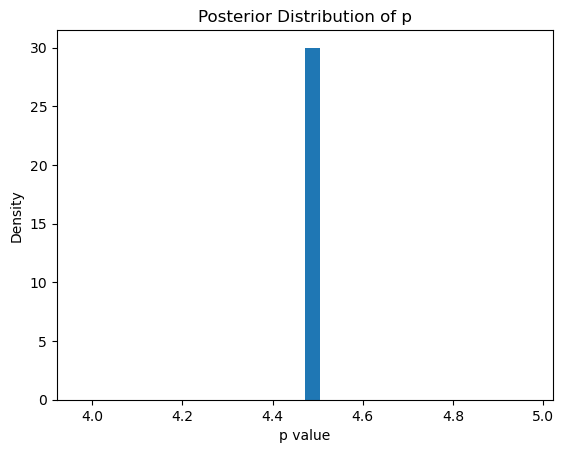

In [47]:
def simulate_dynamics_langevin(n_steps, dt, initial_pos, gamma, k, temperature):
    x = np.zeros(n_steps)
    x[0] = initial_pos

    # Constants for the stochastic term
    sigma = np.sqrt(2 * gamma * temperature * dt)

    for i in range(1, n_steps):
        force = -k * x[i-1]  # Harmonic force
        random_force = np.random.normal(scale=sigma)
        x[i] = x[i-1] + force * dt + random_force

    return x

def exponential_likelihood(lam, data):
    return np.prod(stats.expon.pdf(data, scale=1/lam))

def log_likelihood(lam, data):
    return np.sum(np.log(stats.expon.pdf(data, scale=1/lam)))


# Assume some initial parameters for Langevin dynamics
n_steps = 1000
dt = 0.01
initial_pos = 0.0
gamma = 1.0
k = 1.0
temperature = 1.0

# MCMC parameters
n_samples = 25000
burn_in = 5000
lag = 5
results = []

# Initialize a value of lambda
lam = np.random.uniform(0.1, 10)

for i in range(n_samples):
    # Simulate Langevin dynamics
    x = simulate_dynamics_langevin(n_steps, dt, initial_pos, gamma, k, temperature)

    # Propose a new value of lambda
    lam_new = np.random.uniform(0.1, 10)

    # Calculate the acceptance ratio
    R = np.exp(log_likelihood(lam_new, x) - log_likelihood(lam, x))
    u = np.random.random_sample()

    # Accept or reject the new lambda
    if u < R:
        lam = lam_new

    # Record values after burn-in and according to lag
    if i > burn_in and i % lag == 0:
        results.append(lam)

# Now results contains samples from the posterior of lambda
plt.hist(results, bins=30, density=True)
plt.xlabel('p value')
plt.ylabel('Density')
plt.title('Posterior Distribution of p')
plt.show()

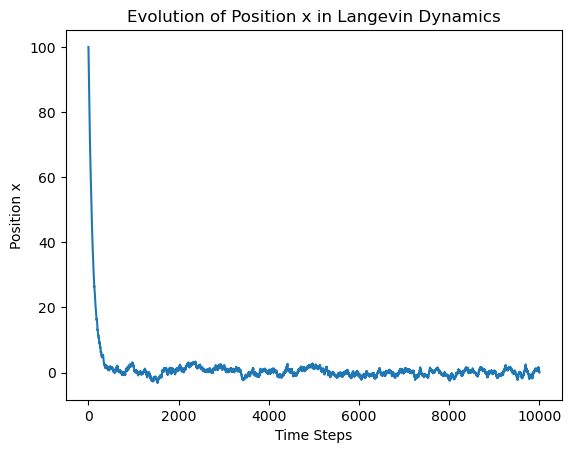

In [53]:
import matplotlib.pyplot as plt


def double_well_potential(x, k=1, x0=0):
    energy = 0.25 * k * (x**2 - x0**2)**2
    force = -k * x * (x**2 - x0**2)
    return energy, force

# Parameters for Langevin dynamics
num_steps = 10000
dt = 0.01
x0 = 100.0  # Starting far from the potential well (x=0)
gamma = 1.0
k = 1.0
temperature = 1.0

# Run simulation
x_values = simulate_dynamics_langevin(num_steps, dt, x0, gamma, k, temperature)

# Plot the trajectory of x
plt.plot(x_values)
plt.xlabel('Time Steps')
plt.ylabel('Position x')
plt.title('Evolution of Position x in Langevin Dynamics')
plt.show()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


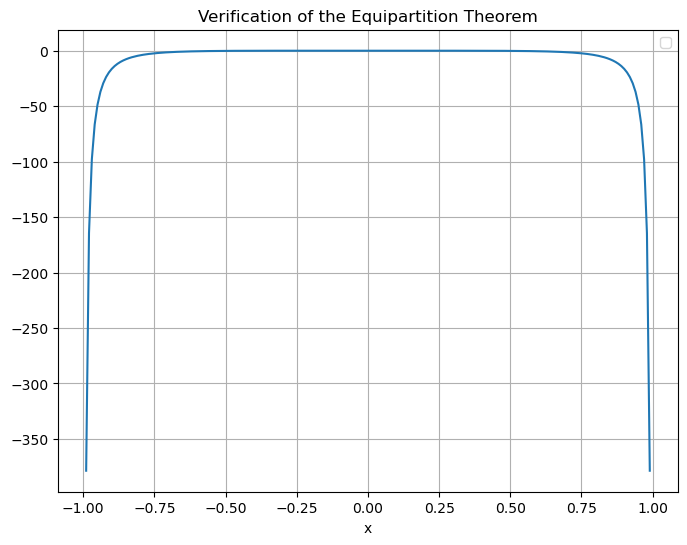

In [75]:
import matplotlib.pyplot as plt
import numpy as np

# Load data from the C++ simulation
data = np.loadtxt('log_values.txt')
x = data[:, 0]
loglike = data[:, 1]
derloglike = data[:, 2]

# Plotting
plt.figure(figsize=(8, 6))
plt.plot(x, loglike)
plt.xlabel('x')
plt.ylabel('log')
plt.title('Verification')
plt.legend()
plt.grid(True)
plt.show()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


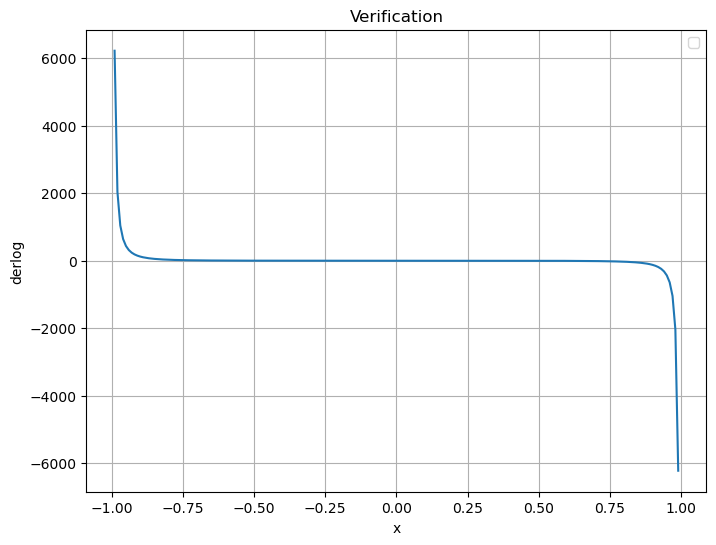

In [77]:
import matplotlib.pyplot as plt
import numpy as np

# Load data from the C++ simulation
data = np.loadtxt('log_values.txt')
x = data[:, 0]
loglike = data[:, 1]
derloglike = data[:, 2]

# Plotting
plt.figure(figsize=(8, 6))
plt.plot(x, derloglike)
plt.xlabel('x')
plt.ylabel('derlog')
plt.title('Verification')
plt.legend()
plt.grid(True)
plt.show()


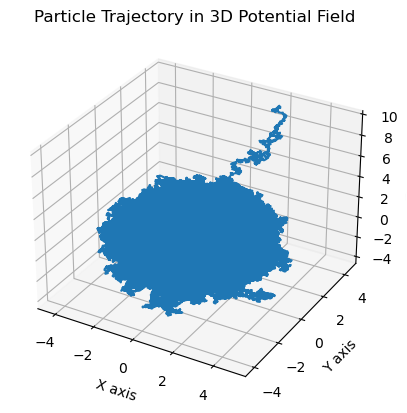

In [3]:
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D

# Load data from the C++ simulation
data = np.loadtxt('trajectory.txt')
x = data[:, 0]
y = data[:, 1]
z = data[:, 2]


fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(x, y, z)
ax.set_xlabel('X axis')
ax.set_ylabel('Y axis')
ax.set_zlabel('Z axis')
ax.set_title('Particle Trajectory in 3D Potential Field')
plt.show()



In [9]:
avg_x2 = np.mean(x**2)
avg_y2 = np.mean(y**2)
avg_z2 = np.mean(z**2)
print(f"The average of x^2 is approximately {avg_x2}, expected is 1.")
print(f"The average of y^2 is approximately {avg_y2}, expected is 1.")
print(f"The average of z^2 is approximately {avg_z2}, expected is 1.")



The average of x^2 is approximately 0.9891372609426158, expected is 1.
The average of y^2 is approximately 0.9882365351933267, expected is 1.
The average of z^2 is approximately 1.014444354322768, expected is 1.


Skip a thousand and call it the burn in stage and do the rest. 



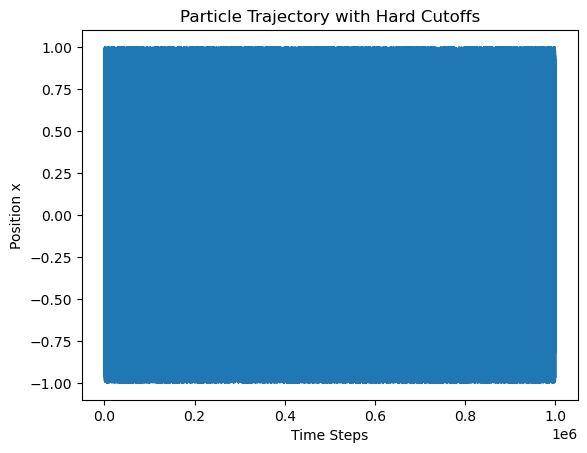

In [121]:
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D

# Load data from the C++ simulation
data = np.loadtxt('trajectory_hard_cut.txt')
x = data

plt.plot(x)
plt.xlabel('Time Steps')
plt.ylabel('Position x')
plt.title('Particle Trajectory with Hard Cutoffs')
plt.show()


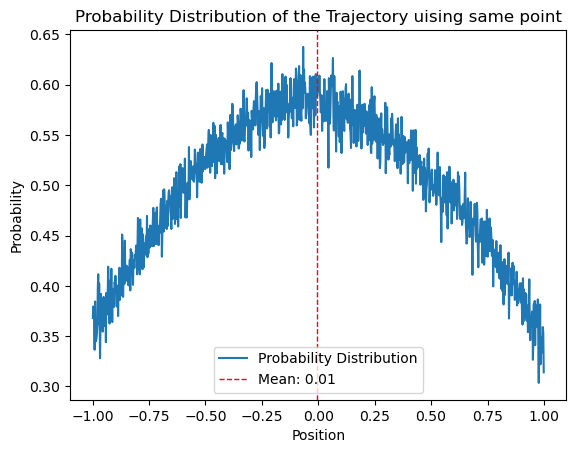

In [132]:
trajectory_1 = np.array(x)  # Ensure it's a NumPy array for easy calculations

# Calculate the histogram
num_bins = 1000  # You can adjust this number based on your data
hist_1, bin_edges_1 = np.histogram(trajectory_1, bins=num_bins, density=True)
mean_trajectory_1 = np.mean(trajectory_1)

bin_centers_1 = 0.5 * (bin_edges_1[1:] + bin_edges_1[:-1])

# Scatter plot of the probability distribution
plt.plot(bin_centers_1, hist_1, label='Probability Distribution')

# Mark the mean of the trajectory
plt.axvline(mean_trajectory_1, cholor='r', linestyle='dashed', linewidth=1, label=f'Mean: {mean_trajectory:.2f}')

plt.xlabel('Position')
plt.ylabel('Probability')
plt.title('Probability Distribution of the Trajectory uising same point')
plt.legend()
plt.show()

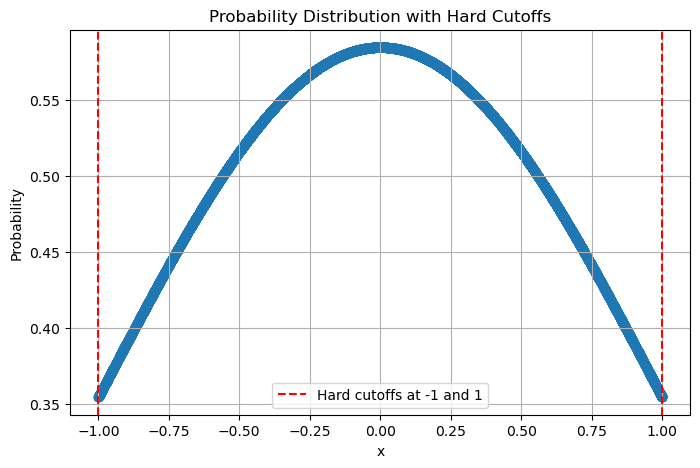

In [32]:

def potential_function_1d(x):
    if x <= -1 or x >= 1:
        return float('inf')  # Represents a hard cutoff
    else:
        # Define the potential within the interval here
        U = 1/2*(x**2)
        return U
    
    
def probability(x):
    U = potential_function_1d(x)
    if U == float('inf'):
        return 0  # Probability is zero outside the [-1, 1] interval
    else:
        return np.exp(-U)/(np.sqrt(2)*1.21002)  
    
x_values = np.linspace(-1.5, 1.5, 10000)
probabilities = np.array([probability(i) for i in x])

plt.figure(figsize=(8, 5))
plt.scatter(x,probabilities)
plt.axvline(-1, color='r', linestyle='--', label='Hard cutoffs at -1 and 1')
plt.axvline(1, color='r', linestyle='--')
plt.xlabel('x')
plt.ylabel('Probability')
plt.title('Probability Distribution with Hard Cutoffs')
plt.legend()
plt.grid(True)
plt.show()

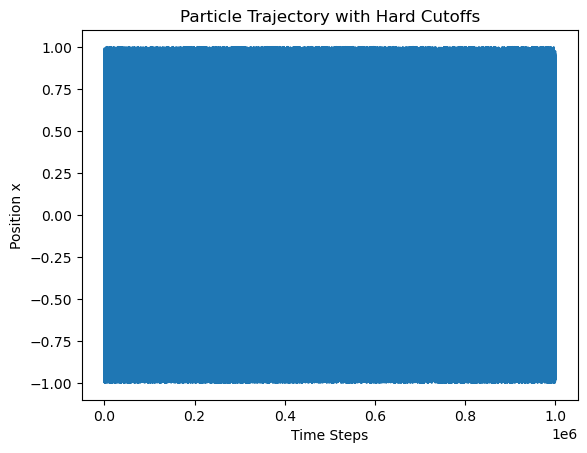

In [129]:
data_2 = np.loadtxt('trajectory_hard_cut_MH.txt')
x_2 = data_2

plt.plot(x_2)
plt.xlabel('Time Steps')
plt.ylabel('Position x')
plt.title('Particle Trajectory with Hard Cutoffs')
plt.show()

In [103]:
x_2[10000000-10000000]

0.5

In [134]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming 'trajectory' is your array of positions from the simulation
trajectory_2 = np.array(x_2)  # Ensure it's a NumPy array for easy calculations

# Calculate the histogram
num_bins = 1000  # You can adjust this number based on your data
hist_2, bin_edges_2 = np.histogram(trajectory_2, bins=num_bins, density=True)
mean_trajectory_2 = np.mean(trajectory_2)


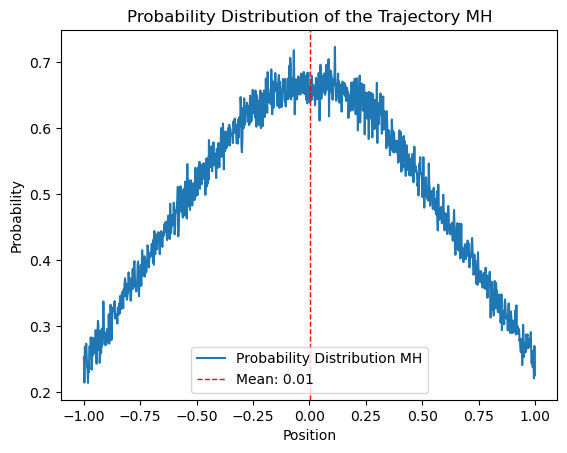

In [136]:
bin_centers_2 = 0.5 * (bin_edges_2[1:] + bin_edges_2[:-1])

# Scatter plot of the probability distribution
plt.plot(bin_centers_2, hist_2, label='Probability Distribution MH')

# Mark the mean of the trajectory
plt.axvline(mean_trajectory_2, color='r', linestyle='dashed', linewidth=1, label=f'Mean: {mean_trajectory:.2f}')

plt.xlabel('Position')
plt.ylabel('Probability')
plt.title('Probability Distribution of the Trajectory MH')
plt.legend()
plt.show()